In [31]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
%matplotlib inline
import matplotlib
import requests
from pandas.io.json import json_normalize 
import time 
import csv
import os
from pprint import pprint


In [32]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

In [33]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5078,40875,NaN,45953,NaN,NaN,164.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,321,9803,NaN,10124,161.0,46.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5064,49436,NaN,54500,1155.0,637.0,187.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,1923,24630,NaN,26553,749.0,93.0,42.0,106,106,106,40,100,46,45,49,5,1
4,California,30978,259522,NaN,290500,NaN,4674.0,1208.0,466,466,466,302,401,18,15,44,16,-17


In [35]:
# Filter the DataFrame down only to those columns to chart
bar_chart_df = comb2_df[["State","Positive","Negative"]]

# Set the index to be "State" so they will be used as labels
bar_chart_df = bar_chart_df.set_index("State")

bar_chart_df.head()

,Positive,Negative
State,,
Alabama,5078,40875
Alaska,321,9803
Arizona,5064,49436
Arkansas,1923,24630
California,30978,259522


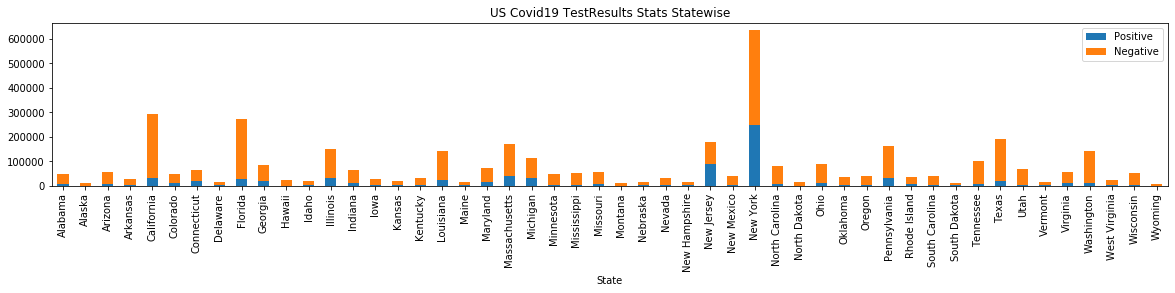

<Figure size 432x288 with 0 Axes>

In [36]:
# Use DataFrame.plot() in order to create a bar chart of the data
bar_chart_df.plot(kind="bar", figsize=(20,3), stacked=True,title = 'US Covid19 TestResults Stats Statewise')

# Display the chart
plt.show()
plt.tight_layout()

# Save the bar chart
plt.savefig('Statewise TestResults Stac Bar Chart')